In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat
import sys

from hloc import extract_features, match_features, localize_inloc, visualization

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# import hloc
print("carefully inspect which hloc it is, whether the docker one or normal modified one.")
# hloc

carefully inspect which hloc it is, whether the docker one or normal modified one.


# Pipeline for indoor localization

## Setup
Here we declare the paths to the dataset, image pairs, and we choose the feature extractor and the matcher. You need to download the [InLoc dataset](https://www.visuallocalization.net/datasets/) and put it in `datasets/inloc/`, or change the path.

In [4]:
dataset = Path('datasets/inloc_small/')  # change this if your dataset is somewhere else

pairs = Path('pairs/inloc_small/')
loc_pairs = pairs / 'pairs-query-netvlad40-custom-shub-small-noDUC2.txt'  # top 40 retrieved by NetVLAD

outputs = Path('outputs/inloc_small/')  # where everything will be saved
results = outputs / 'InLoc_hloc_superpoint+superglue_netvlad40.txt'  # the result file

In [5]:
# list the standard configurations available
# print(f'Configs for feature extractors:\n{pformat(extract_features.confs)}')
# print(f'Configs for feature matchers:\n{pformat(match_features.confs)}')

In [6]:
# pick one of the configurations for extraction and matching
# you can also simply write your own here!
feature_conf = extract_features.confs['superpoint_inloc']
matcher_conf = match_features.confs['superglue']

## Extract local features for database and query images

In [7]:
feature_path = extract_features.main(feature_conf, dataset, outputs)

[11/16/2021 16:45:34 INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}
[11/16/2021 16:45:34 INFO] Found 3956 images in root datasets/inloc_small.
[11/16/2021 16:45:37 INFO] Skipping the extraction.


## Match the query images
Here we assume that the localization pairs are already computed using image retrieval (NetVLAD). To generate new pairs from your own global descriptors, have a look at `hloc/pairs_from_retrieval.py`. These pairs are also used for the localization - see below.

In [8]:
match_path = match_features.main(matcher_conf, loc_pairs, feature_conf['output'], outputs)

[11/16/2021 16:45:37 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 39/39 [00:00<00:00, 310984.52it/s]

[11/16/2021 16:45:47 INFO] Finished exporting matches.


## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. Different from when localizing with Aachen, here we do not need a 3D SfM model here: the dataset already has 3D lidar scans. The file `InLoc_hloc_superpoint+superglue_netvlad40.txt` will contain the estimated query poses.

In [9]:
localize_inloc.main(
    dataset, loc_pairs, feature_path, match_path, results,
    skip_matches=20)  # skip database images with too few matches

  0%|          | 0/1 [00:00<?, ?it/s]

datasets/inloc_small/cutouts_imageonly/DUC1/084/DUC_cutout_084_0_-30.jpg.mat
datasets/inloc_small/cutouts_imageonly/DUC1/084/DUC_cutout_084_0_0.jpg.mat
datasets/inloc_small/cutouts_imageonly/DUC1/084/DUC_cutout_084_0_30.jpg.mat
datasets/inloc_small/cutouts_imageonly/DUC1/084/DUC_cutout_084_120_-30.jpg.mat
datasets/inloc_small/cutouts_imageonly/DUC1/084/DUC_cutout_084_120_0.jpg.mat
datasets/inloc_small/cutouts_imageonly/DUC1/084/DUC_cutout_084_120_30.jpg.mat
len(pcd.points): 11520000
After downsampling: 857862
[0.05167549 0.05167549 0.05167549]
[[  1.           0.           0.          14.19256955]
 [ -0.          -1.          -0.          20.94467112]
 [ -0.          -0.          -1.         134.55330458]
 [  0.           0.           0.           1.        ]]


  0%|          | 0/1 [00:04<?, ?it/s]


SystemExit: 

/home/shubodh/anaconda3/envs/hloc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Visualization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

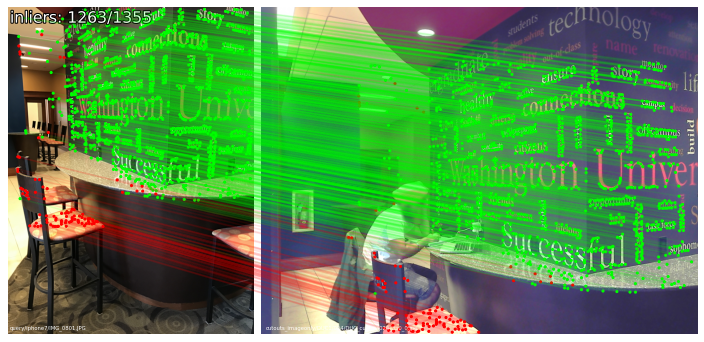

In [9]:
visualization.visualize_loc(results, dataset, n=1, top_k_db=1, seed=2)